In [ ]:
# Uncomment if running from Google Colab
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
%cd gdrive/MyDrive/Masters_Project
%pip install -e peratouch

In [ ]:
from peratouch.data import Data, load_data
from peratouch.trainer import Trainer 
from peratouch.results import Results 
from peratouch.networks import CNN
from peratouch.config import path_five_users_main, path_five_users_first
import sklearn

def run_dataset(X, y, n_folds=5, plotting=False):
    """
    Runs entire routine of fitting CNN model to dataset (X, y)self.
    Performs Cross-Validation of n_folds on input dataset.
    Assumes data is already shuffled.
    """

    D = Data(X, y)

    # Create indices of several folds
    D.make_folds(n_folds)     # Makes indices available inside class

    predictions = []
    actual_vals = []

    for i in range(n_folds):     # Run all folds n_folds
        D.next_fold()
        D.normalize()
        D.tensors_to_device()
        D.print_shapes()
        model = CNN(n_ch=1)      # Initialize new model each fold
        T = Trainer(D)
        T.setup(model, max_epochs=50, batch_size=int(len(D.xtr)/20))       # 20 minibatches
        T.train_model(model)
        if (plotting & (i==0)):
            T.plot_train()
        R = Results(D, model)
        R.test_metrics()
        preds, actual = R.get_preds_actual()

        predictions.extend(preds)
        actual_vals.extend(actual)

    print(sklearn.metrics.classification_report(actual_vals, predictions))
    return actual_vals, predictions

In [1]:
# Run CNN routine for datasets with different sizes
# Goal is to analyse how dataset size affects performance

# The routine below is a dirty trick using the capabilities of k-fold from sklearn
# Takes test set from k-fold and uses it to subsample the raw dataset
# Used it like this because it automates the majority of the work
from peratouch.config import path_analysis_results
from datetime import date
import numpy as np

Xraw, yraw = load_data(path_five_users_main)
# Shuffle data to destroy ordering of users
Xraw, yraw = sklearn.utils.shuffle(Xraw, yraw, random_state=42)

results_dict = {}

for n_splits in [1, 2, 3, 5, 10, 20, 40]:         # Splits of raw dataset
    print("\n\n--- Testing new dataset size ---\n\n")

    actual_vals, predictions = [], []
    n_folds = 5      # Number of folds to run for each dataset

    if n_splits==1:    # Case of entire dataset
        X = Xraw
        y = yraw
        actual, preds = run_dataset(X, y, n_folds, plotting=True)
        actual_vals.extend(actual)
        predictions.extend(preds)

    else:    
      kf = sklearn.model_selection.KFold(n_splits)       # No shuffling
      for i, (_, data_idx) in enumerate(kf.split(Xraw)):
          print("\n-- New splitting of dataset --\n")

          # if i>0: break

          X = Xraw[data_idx]
          y = yraw[data_idx]
          
          plotting = True if i==0 else False  # Plot on first split

          actual, preds = run_dataset(X, y, n_folds, plotting)

          actual_vals.extend(actual)
          predictions.extend(preds)

    # NOTE: Hardcoded value of 0.85 below is the split between training and validation sets
    tr_size = int(len(X)*(n_folds-1)/n_folds * 0.85)         # Training size is size of all folds except one 
    results_dict[str(tr_size)] = (actual_vals, predictions)
    filename = str(path_analysis_results / f"dataset_size_{date.today()}.npz") 
    np.savez(filename, **results_dict)



--- Testing new dataset size ---



-- New splitting of dataset --



-- New Fold --
Train, test and validation arrays normalized to:
[1.], [0.9987], [0.9982]
Using Device:  cpu , dtype:  torch.float32

Raw data shape:  (53213, 1, 32) 
Labels shape:  (53213,) 
Shape of test set: (10643, 1, 32) 
Shape of train set: (36184, 1, 32) 
Shape of validation set: (6386, 1, 32) 
Unique labels:  [0 1 2 3 4] 
Fraction of test labels:  [0.23, 0.18, 0.22, 0.2, 0.17] 
Fraction of validation labels:  [0.22, 0.19, 0.21, 0.21, 0.17] 
Fraction of train labels:  [0.22, 0.19, 0.21, 0.21, 0.17] 
dtype of inputs:  torch.float32

 Start of training model:

End of epoch 1: loss_tr=1.124, loss_val=1.130, train=57.4%, val=57.1%
End of epoch 11: loss_tr=0.865, loss_val=0.874, train=67.3%, val=67.1%
End of epoch 21: loss_tr=0.878, loss_val=0.888, train=65.7%, val=65.1%
End of epoch 31: loss_tr=0.857, loss_val=0.862, train=66.7%, val=66.4%
End of epoch 41: loss_tr=0.859, loss_val=0.867, train=66.8%, val=66.0%
End

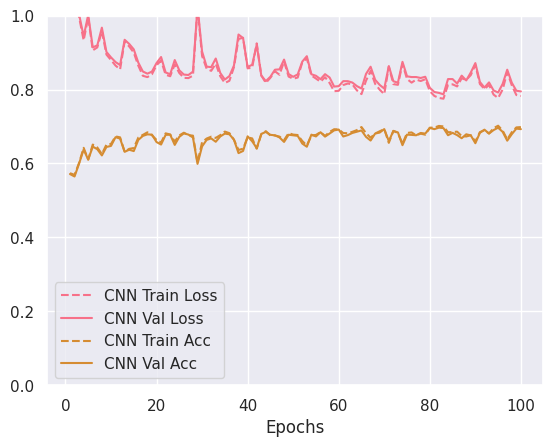

In [2]:
# Loads data from stored dict
stored_results = np.load(filename)

print("len of raw data: ", len(Xraw))
for key in stored_results:
    print(key, " : ", len(results_dict[key][0]))
    print(sklearn.metrics.classification_report(*results_dict[key]))